In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
from keras.preprocessing import image                  
from tqdm import tqdm
from PIL import ImageFile  
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint  
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras.layers import BatchNormalization
from keras.regularizers import l1, l2
from keras.layers import GaussianNoise
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
import keras 
from keras.models import Model
from keras.applications import MobileNet
from keras.applications import MobileNetV2
import time

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    images = np.array(data['filenames'])
    images_targets = np_utils.to_categorical(np.array(data['target']), 5) # [1,0] is no_punch, [0,1] is right_punch
    return images, images_targets

#load training dataset
train_images, train_targets = load_dataset('../Images/train') 
test_images, test_targets = load_dataset('../Images/test')

print('There are %s total training images.\n' % len(train_images))
print('There are %s total testing images.\n' % len(test_images))

Using TensorFlow backend.


There are 2394 total training images.

There are 242 total testing images.



In [10]:
# Create functions to load the images into 4D numpy tensors, load data into tensors and create a training-validation split
# out of the training data.

# Functions to load images into 4d Numpy arrays.
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process and load the data for Keras
train_tensors = paths_to_tensor(train_images).astype('float32')/255
test_tensors = paths_to_tensor(test_images).astype('float32')/255

100%|██████████| 242/242 [00:14<00:00, 16.74it/s]


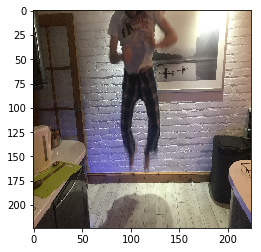

array([0., 1., 0., 0., 0.], dtype=float32)

In [17]:
import matplotlib.pyplot as plt


plt.imshow(train_tensors[416, :,:,:])
plt.show()

train_targets[416]



In [ ]:
# Visualize some of the training tensors
import matplotlib.pyplot as plt

for i in range (400,425):
    plt.imshow(train_tensors[i, :,:,:])
    plt.show()
    print(train_targets[i])

In [4]:

# Split the training data into training and validation sets.
train_tensors, valid_tensors, train_targets, valid_targets = train_test_split(train_tensors, train_targets, 
                                                                             test_size=0.2, 
                                                                             random_state=42)

In [5]:
# Set some adjustable variables outside the function and setup CNN compiling, fiting and testing function with early-stopping
# and model-checkpointing. Reload best weights and test model with best weights on testing set.

epochs = 1000
patience = 20
rmsprop_lowLR = optimizers.RMSprop(lr=0.00001)
optimizer= rmsprop_lowLR

def model_compile_fit(model):
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    print("Optimizer:", optimizer)
    print("Patience:", patience)
    
    checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)
    
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0, mode='auto', 
          baseline=None, restore_best_weights=False)
    
    model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer,
          early_stopping], verbose=2)
    
    model.load_weights('saved_models/weights.best.from_scratch.hdf5')
    
    # get index of predicted action for each image in test set
    action_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

    # report test accuracy
    test_accuracy = 100*np.sum(np.array(action_predictions)==np.argmax(test_targets, axis=1))/len(2) #len(2) is len(diff actions)
    print('Test accuracy: %.4f%%' % test_accuracy)
              


In [6]:
#Same function as above but with ImageDataGenerator to allow image augmentation.

def augmented_data_model_compile_fit(model):
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    print("Optimizer:", optimizer)
    print("Patience:", patience)
    
    checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)
    
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0, mode='auto', 
          baseline=None, restore_best_weights=False)
    
    #Create and configure augmented image generator

    datagen =ImageDataGenerator(width_shift_range=0.1, # randomly shift images horizontally (10% of total width)
                                height_shift_range=0.1, # randomly shift images vertically (10% of total height)
                                zoom_range=0.2) # range for random zoom)
              
    
    #fit augmented image generator on data
    datagen.fit(train_tensors)
    
    batch_size = 20
    
    # train the model
    model.fit_generator(datagen.flow(train_tensors, train_targets, batch_size=batch_size),
                          steps_per_epoch=3*(train_tensors.shape[0]//batch_size),
                          epochs=epochs, verbose=2, callbacks=[checkpointer, early_stopping],
                         validation_data=(valid_tensors, valid_targets))
    
    # load the weights that generated the best validation accuracy
    model.load_weights('saved_models/weights.best.from_scratch.hdf5')
       
    # get index of predicted action for each image in test set
    action_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

    # report test accuracy
    test_accuracy = 100*np.sum(np.array(action_predictions)==np.argmax(test_targets, axis=1))/len(action_predictions) 
    print('Test accuracy: %.4f%%' % test_accuracy)

In [ ]:
patience= 15

aug_model9 = Sequential()
aug_model9.add(Conv2D(input_shape=(224,224,3), filters=16, kernel_size=(5,5), padding='same', activation='relu', strides=1))
aug_model9.add(MaxPooling2D(pool_size=(3,3)))
aug_model9.add(BatchNormalization())
aug_model9.add(Conv2D(input_shape=train_tensors.shape, filters=32, kernel_size=(4,4), padding='same', activation='relu', strides=1))
aug_model9.add(MaxPooling2D(pool_size=(2,2)))
aug_model9.add(BatchNormalization())
aug_model9.add(Conv2D(input_shape=train_tensors.shape, filters=64, kernel_size=(3,3), padding='same', activation='relu'))
aug_model9.add(MaxPooling2D(pool_size=(2,2), strides=1))
aug_model9.add(BatchNormalization())
aug_model9.add(Conv2D(input_shape=(224,224,3), filters=128, kernel_size=(3,3), padding='same', activation='relu'))
aug_model9.add(MaxPooling2D(pool_size=(2,2), strides=1))
aug_model9.add(BatchNormalization())
aug_model9.add(Conv2D(input_shape=(224,224,3), filters=256, kernel_size=(3,3), padding='same', activation='relu'))
aug_model9.add(MaxPooling2D(pool_size=(2,2), strides=1))
aug_model9.add(BatchNormalization())
aug_model9.add(Conv2D(input_shape=(224,224,3), filters=512, kernel_size=(3,3), padding='same', activation='relu'))
aug_model9.add(MaxPooling2D(pool_size=(2,2), strides=1))
aug_model9.add(BatchNormalization())
aug_model9.add(Conv2D(input_shape=(224,224,3), filters=1024, kernel_size=(3,3), padding='same', activation='relu'))
aug_model9.add(MaxPooling2D(pool_size=(2,2), strides=1))
aug_model9.add(BatchNormalization())
aug_model9.add(GlobalAveragePooling2D(data_format=None))
aug_model9.add(Dense(3, activation = 'softmax'))

aug_model9.summary()
augmented_data_model_compile_fit(aug_model9)

In [ ]:
# load the weights that generated the best validation accuracy
aug_model9.load_weights('saved_models/weights.best.from_scratch.hdf5')
       
# get index of predicted action for each image in test set
action_predictions = [np.argmax(aug_model9.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(action_predictions)==np.argmax(test_targets, axis=1))/len(action_predictions) 
print('Test accuracy: %.4f%%' % test_accuracy)

In [ ]:
# load the weights that generated the best validation accuracy
transfer_model.load_weights('saved_models/weights.best.transfer.hdf5')
       
# get index of predicted action for each image in test set
action_predictions = [np.argmax(transfer_model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_bottlenecks]

# report test accuracy
test_accuracy = 100*np.sum(np.array(action_predictions)==np.argmax(test_targets, axis=1))/len(action_predictions) 
print('Test accuracy: %.4f%%' % test_accuracy)

In [6]:
###### Fine tuning MobileNetV1
patience = 15

# create the base pre-trained model
base_model = MobileNet(weights='imagenet', include_top=False)

base_model.summary()

c:\users\gblan\appdata\local\conda\conda\envs\deeplearning\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128       
__________

In [7]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

# this is the model we will train
mobilenetV1_model = Model(inputs=base_model.input, outputs=predictions)
mobilenetV1_model.summary()

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(fine_tuned_model.layers):
    print(i, layer.name)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128       
__________

NameError: name 'fine_tuned_model' is not defined

In [ ]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in mobilenetV1_model.layers[:20]:
    layer.trainable = False
for layer in mobilenetV1_model.layers[20:]:
    layer.trainable = True

In [8]:

# compile the model (should be done *after* setting layers to non-trainable)
mobilenetV1_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0003), metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0, mode='auto', 
          baseline=None, restore_best_weights=False)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.MobileNetV1.hdf5', 
                               verbose=1, save_best_only=True)

mobilenetV1_model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer, early_stopping], verbose=2)

Train on 1582 samples, validate on 396 samples
Epoch 1/1000
 - 16s - loss: 0.2571 - acc: 0.9001 - val_loss: 0.0934 - val_acc: 0.9722

Epoch 00001: val_loss improved from inf to 0.09336, saving model to saved_models/weights.best.MobileNetV1.hdf5
Epoch 2/1000
 - 12s - loss: 0.0447 - acc: 0.9861 - val_loss: 0.0544 - val_acc: 0.9747

Epoch 00002: val_loss improved from 0.09336 to 0.05439, saving model to saved_models/weights.best.MobileNetV1.hdf5
Epoch 3/1000
 - 12s - loss: 0.0302 - acc: 0.9867 - val_loss: 0.2491 - val_acc: 0.9293

Epoch 00003: val_loss did not improve from 0.05439
Epoch 4/1000
 - 12s - loss: 0.0163 - acc: 0.9930 - val_loss: 0.0073 - val_acc: 0.9975

Epoch 00004: val_loss improved from 0.05439 to 0.00733, saving model to saved_models/weights.best.MobileNetV1.hdf5
Epoch 5/1000
 - 12s - loss: 0.0289 - acc: 0.9918 - val_loss: 5.2450e-04 - val_acc: 1.0000

Epoch 00005: val_loss improved from 0.00733 to 0.00052, saving model to saved_models/weights.best.MobileNetV1.hdf5
Epoch 6

In [14]:
# load the weights that generated the best validation accuracy
mobilenetV1_model.load_weights('saved_models/weights.best.MobileNetV1.hdf5')
       
# get index of predicted action for each image in test set
action_predictions = [np.argmax(mobilenetV1_model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(action_predictions)==np.argmax(test_targets, axis=1))/len(action_predictions) 
print('Test accuracy: %.4f%%' % test_accuracy)

#Compute average prediction time
computational_times = []

for i in range(50):
    
    start = time.time()
    mobilenetV1_model.predict(np.expand_dims(test_tensors[i], axis=0))
    end = time.time()
    
    elapsed = end - start
    computational_times.append(elapsed)

print("Average computational time per prediction:", np.sum(computational_times)/len(computational_times)*1000, "ms")

Test accuracy: 99.3421%
Average computational time per prediction: 4.060111045837402 ms


In [7]:
###### Fine tuning MobileNetV2
patience = 10

# create the base pre-trained model
base_model = MobileNetV2(weights='imagenet', include_top=False)

base_model.summary()

c:\users\gblan\appdata\local\conda\conda\envs\deeplearning\lib\site-packages\keras_applications\mobilenet_v2.py:306: UserWarning: MobileNet shape is undefined. Weights for input shape(224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

__________________________________________________________________________________________________
block_8_project (Conv2D)        (None, None, None, 6 24576       block_8_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_8_project_BN (BatchNormal (None, None, None, 6 256         block_8_project[0][0]            
__________________________________________________________________________________________________
block_8_add (Add)               (None, None, None, 6 0           block_7_add[0][0]                
                                                                 block_8_project_BN[0][0]         
__________________________________________________________________________________________________
block_9_expand (Conv2D)         (None, None, None, 3 24576       block_8_add[0][0]                
__________________________________________________________________________________________________
block_9_ex

In [8]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

# this is the model we will train
mobilenetV2_model = Model(inputs=base_model.input, outputs=predictions)
mobilenetV2_model.summary()

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(fine_tuned_model.layers):
    print(i, layer.name)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

__________________________________________________________________________________________________
block_8_project (Conv2D)        (None, None, None, 6 24576       block_8_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_8_project_BN (BatchNormal (None, None, None, 6 256         block_8_project[0][0]            
__________________________________________________________________________________________________
block_8_add (Add)               (None, None, None, 6 0           block_7_add[0][0]                
                                                                 block_8_project_BN[0][0]         
__________________________________________________________________________________________________
block_9_expand (Conv2D)         (None, None, None, 3 24576       block_8_add[0][0]                
__________________________________________________________________________________________________
block_9_ex

Total params: 3,572,803
Trainable params: 3,538,691
Non-trainable params: 34,112
__________________________________________________________________________________________________


NameError: name 'fine_tuned_model' is not defined

In [ ]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in mobilenetV2_model.layers[:70]:
    layer.trainable = False
for layer in mobilenetV2_model.layers[70:]:
    layer.trainable = True

In [9]:
# compile the model (should be done *after* setting layers to non-trainable)
mobilenetV2_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0003), metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0, mode='auto', 
          baseline=None, restore_best_weights=False)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.MobileNetV2.hdf5', 
                               verbose=1, save_best_only=True)

mobilenetV2_model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer, early_stopping], verbose=2)

Train on 1582 samples, validate on 396 samples
Epoch 1/1000
 - 22s - loss: 0.3121 - acc: 0.8710 - val_loss: 0.0088 - val_acc: 0.9949

Epoch 00001: val_loss improved from inf to 0.00877, saving model to saved_models/weights.best.MobileNetV2.hdf5
Epoch 2/1000
 - 15s - loss: 0.0311 - acc: 0.9874 - val_loss: 0.0118 - val_acc: 0.9949

Epoch 00002: val_loss did not improve from 0.00877
Epoch 3/1000
 - 15s - loss: 0.0333 - acc: 0.9893 - val_loss: 0.0103 - val_acc: 0.9975

Epoch 00003: val_loss did not improve from 0.00877
Epoch 4/1000
 - 15s - loss: 0.0069 - acc: 0.9975 - val_loss: 0.0074 - val_acc: 0.9975

Epoch 00004: val_loss improved from 0.00877 to 0.00739, saving model to saved_models/weights.best.MobileNetV2.hdf5
Epoch 5/1000
 - 15s - loss: 0.0231 - acc: 0.9899 - val_loss: 0.0512 - val_acc: 0.9924

Epoch 00005: val_loss did not improve from 0.00739
Epoch 6/1000
 - 15s - loss: 0.0099 - acc: 0.9962 - val_loss: 0.0972 - val_acc: 0.9571

Epoch 00006: val_loss did not improve from 0.00739
E

In [10]:
# load the weights that generated the best validation accuracy
mobilenetV2_model.load_weights('saved_models/weights.best.MobileNetV2.hdf5')
       
# get index of predicted action for each image in test set
action_predictions = [np.argmax(mobilenetV2_model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(action_predictions)==np.argmax(test_targets, axis=1))/len(action_predictions) 
print('Test accuracy: %.4f%%' % test_accuracy)

#Compute average prediction time
computational_times = []

for i in range(50):
    
    start = time.time()
    mobilenetV2_model.predict(np.expand_dims(test_tensors[i], axis=0))
    end = time.time()
    
    elapsed = end - start
    computational_times.append(elapsed)

print("Average computational time per prediction: {.3f} ms".format(np.sum(computational_times)/len(computational_times)*1000) m")

Test accuracy: 100.0000%
Average computational time per prediction: 7.001848220825195 ms
